<a href="https://colab.research.google.com/github/nathanchandanson/Majeure-STIC/blob/master/OS202/Seance_5/tp_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurer votre colab pour le calcul sur GPU
Dans le menu au dessus, choisir le sous-menu **Exécution** puis l'option **Modifier le type d'exécution**.

Une fenêtre apparaît où vous pouvez choisir un accélérateur matériel. Choisissez un *GPU* puis *enregistrer* votre choix.

Afin de vérifier que vous avez bien configuré votre session pour utiliser un GPU, exécuter le code ci-dessous (en passant la souris, une petite flèche pour l'exécuter apparaît).

Si tout se passe bien, un tableau (en ascii) apparaît avec le type de carte (et son architecture) auquel vous avez accès. Si un message d'erreur apparaît, vérifiez dans **Modifier le type d'exécution** que l'accélérateur matériel est bien configuré pour un *GPU*

In [1]:
!nvidia-smi

Tue Mar  4 10:16:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   74C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Installation de PyCuda

Pour utiliser le GPU sous Python il faut soit installer **PyCuda** pour effectuer des calculs, soit **PyTorch** pour effectuer du machine learning accéléré par les GPUs.

Dans ce TP, nous nous bornerons uniquement à effectuer des calculs sur GPU !

Pour cela, il faut d'abord installer pyCuda et donc exécuter le code ci-dessous (toujours en appuyant sur la flèche pour exécuter le code, et attendez, cela prend un petit moment...)

In [2]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.6 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1-cp311-cp311-linux_x86_64.whl size=660393 sha256=7d8b569f0babe7627a663ac4871e03e30d00490e2c0a0535acd0a74b4c85b105
  Stored in directory: /root/.cache/pip/wheels/77/7e/6c/d2d1451ea6424cdc3d67b36c16fa7111eafdf2034bc3405666
Successfully built pycuda


# Vérification du bon fonctionnement du module PyCuda

Afin de vérifier le bon fonctionnement de l'installation, nous allons écrire un script Cuda qui servira en même temps d'exemple pour le TP d'aujourd'hui. Ce script sera scindé en plusieurs morceaux et commenté pour que vous compreniez chaque partie du code.

Ce code sera très simple : on va créer une matrice 4x4 avec des données prises "au hasard" (mais avec une graine aléatoire fixée, donc...) , recopier ce tableau dans la mémoire de la carte graphique et demander à la carte graphique de doubler la valeur de chaque élément de la matrice puis de recopier dans la mémoire de l'ordinateur les valeurs calculées. On affiche ensuite la matrice initiale et la matrice transformée.

Dans un premier temps, chargeons les modules python nécessaire à l'exécution d'un noyau Cuda (**Remarque** : l'importation de ces modules n'est nécessaire qu'une seule fois pour **TOUTE** la session. Il sera donc inutile de reimporter ces modules dans le reste du TD !) :

In [3]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

Créons à l'aide de numpy un tableau *a* dont les valeurs aléatoires sont issues d'une graine fixée :

In [4]:
import numpy
numpy.random.seed(1729)
a = numpy.random.randn(4,4) # Sous forme de matrice 4 x 4

Puisque certaines cartes graphiques supportent mal le double précision, nous allons demander à Python que les éléments de *a* soient en simple précision :

In [5]:
a = a.astype(numpy.float32)
print(a.nbytes)

64


Nous allons ensuite allouer de la place mémoire sur la mémoire vive du GPU. Comme en C, la place mémoire est exprimée en *Octets* :

In [6]:
a_gpu = cuda.mem_alloc(a.nbytes)

Une fois la réservation sur le GPU de faite, on recopie les valeurs de *a* dans le tableau *a_gpu* que l'on vient de réserver (htod signifie host **to** device):

In [7]:
cuda.memcpy_htod(a_gpu, a)

Il faut ensuite écrire le noyau qui s'exécutera sur la carte graphique à l'aide du langage CUDA (qui est une extension du langage C).

**Remarquez** dans le code qu'on s'assure que les indices donnés par les numéros de threads ne dépassent pas la dimension de la matrice !

In [8]:
mod = SourceModule("""
__global__ void doublify( int dim_x, int dim_y, float *a )
{
  if ((threadIdx.x < dim_x) && (threadIdx.y < dim_y))
  {
    int idx = threadIdx.x + threadIdx.y * dim_x;
    a[idx] *= 2;
  }
}
""")

Nous allons récupérer ensuite un "handle" sur le noyau cuda que l'on vient de créer (en invoquant le nom de la fonction) et l'invoquer sur la carte graphique en dimensionnant la grille de calcul à l'aide de *block=(4,4,1)* (et en l'adaptant aux dimensions de la matrice).

Ici, nous n'avons pas besoin de configurer de grilles car la dimension de la matrice *a* est petite, mais comme la taille d'un bloc dans une direction est limitée à 256, pour des cas plus gros, il faudra également passer une grille en paramètre à l'aide de *grid=(x,y,z)* où *x,y* et *z* sont des valeurs entières positives et utiliser dans le noyau cuda les valeurs *x,y* et *z* de **blockIdx** et **blockDim**.

**REMARQUE IMPORTANTE** : Le noyau cuda ne veut que des types C basiques en argument. Or un entier python est tout sauf un type basique du C. Donc pour passer un argument entier à un noyau cuda, il faut créer un entier 32 bits à l'aide de numpy.int32

In [9]:
func = mod.get_function("doublify")
dim = numpy.int32(4)
func(dim, dim, a_gpu, block=(4,4,1))

Il ne reste plus qu'à récupérer les nouvelles valeurs de la matrice en transférant les données de la matrice contenue par le GPU dans un tableau numpy se trouvant dans la RAM de l'ordinateur (dtoh signifie device **to** host) :

In [10]:
a_doubled = numpy.empty_like(a)
cuda.memcpy_dtoh(a_doubled, a_gpu)

Il ne reste plus qu'à afficher la matrice initiale puis la matrice obtenue par le calcul sur GPU :

In [11]:
print(f"a : {a}")
print(f"a_gpu : {a_doubled}")

a : [[-0.6873394  -0.82099473  1.6523609  -0.57529306]
 [ 1.0989678   0.92594606 -0.9934138  -0.8582211 ]
 [ 0.07488676  0.5293555   0.12095155 -0.22442362]
 [-1.5566785   0.05594088  0.16147153 -2.1346416 ]]
a_gpu : [[-1.3746789  -1.6419895   3.3047218  -1.1505861 ]
 [ 2.1979356   1.8518921  -1.9868276  -1.7164422 ]
 [ 0.14977352  1.058711    0.2419031  -0.44884723]
 [-3.113357    0.11188176  0.32294306 -4.2692833 ]]


## Exercices de mises en bouche

En vous inspirant du programme commenté ci-dessus, écrivez un code avec un noyau Cuda qui fait la somme de deux vecteurs de réels simples précisions et qui range le résultat dans un troisième vecteur.

On s'exercera à utiliser des vecteurs de "grandes" dimensions (> 256) afin de s'entrainer à calculer des indices globaux dans le noyau cuda à l'aide de *threadIdx.x*, *blockIdx.x* et *dimBlock.x*.

Ecrivez (ou copier coller) votre code dans la cellule ci-dessous

In [12]:
############# Création des vecteurs #############
# Taille du vecteur
size = numpy.int32(512)
# Vecteur a
numpy.random.seed(15436)
a = numpy.random.randn(size) # Vecteur 1
a = a.astype(numpy.float32)
# Vecteur b
numpy.random.seed(98841)
b = numpy.random.randn(size) # Vecteur 2
b = b.astype(numpy.float32)
# Vecteur c = a + b
c = numpy.empty(size)
c = c.astype(numpy.float32)

############# Mise en place des vecteurs sur la mémoire GPU #############
# Allocation mémoire
a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)
c_gpu = cuda.mem_alloc(c.nbytes)
# Déplacement données
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

############# Création de la fonction #############
mod = SourceModule("""
__global__ void add_vec( int dim, float *a, float* b, float *c )
{
  int idx = threadIdx.x + blockIdx.x * blockDim.x;
  if ((idx < dim))
  {
    c[idx] = a[idx] + b[idx];
  }
}
""")

############# Appel de la fonction #############
func = mod.get_function("add_vec")
dimgrd = (int(size//256), 1, 1)
func(size, a_gpu, b_gpu, c_gpu, grid=dimgrd, block=(256,1,1))

############# Récupération du résultat #############
cuda.memcpy_dtoh(c, c_gpu)

/usr/local/lib/python3.11/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


Une fois le code mis au point, recopiez le ci-dessous et adaptez le pour additionner deux matrices carrées dans une troisième.

In [17]:
############# Création des matrices #############
# Taille du vecteur
dim = numpy.int32(512)
# Vecteur a
numpy.random.seed(15436)
a = numpy.random.randn(dim,dim) # Vecteur 1
a = a.astype(numpy.float32)
# Vecteur b
numpy.random.seed(98841)
b = numpy.random.randn(dim,dim) # Vecteur 2
b = b.astype(numpy.float32)
# Vecteur c = a + b
c = numpy.empty_like(a)
c = c.astype(numpy.float32)

############# Mise en place des vecteurs sur la mémoire GPU #############
# Allocation mémoire
a_gpu = cuda.mem_alloc(a.nbytes)
b_gpu = cuda.mem_alloc(b.nbytes)
c_gpu = cuda.mem_alloc(c.nbytes)
# Déplacement données
cuda.memcpy_htod(a_gpu, a)
cuda.memcpy_htod(b_gpu, b)

############# Création de la fonction #############
mod = SourceModule("""
__global__ void add_mat( int dim, float *a, float *b, float *c )
{
  int idx = threadIdx.x + blockIdx.x * blockDim.x;
  int idy = threadIdx.y + blockIdx.y * blockDim.y;
  int index = idx + idy * dim;
  if ((idx < dim) && (idy < dim))
  {
    c[index] = a[index] + b[index];
  }
}
""")

############# Appel de la fonction #############
func = mod.get_function("add_mat")
dimgrd = (int(dim//16), int(dim//16), 1)
func(dim, a_gpu, b_gpu, c_gpu, grid=dimgrd, block=(16,16,1))

############# Récupération du résultat #############
cuda.memcpy_dtoh(c, c_gpu)

# Exercice final

Nous allons de nouveau nous intéresser à l'ensemble de Mandelbrot. La cellule ci-dessous contient un code permettant de calculer à l'aide de numpy un ensemble de mandelbrot (le code est simplifié par rapport aux codes sur CPU pour faciliter le TP même si il utilise la notation vectorielle de numpy (il faudra y faire attention pour code le noyau cuda !) : code repris de https://stackoverflow.com/questions/60467316/displaying-mandelbrot-set-in-python-using-matplotlib-pyplot-and-numpy).

Transformez le de sorte que sur GPU, chaque thread calcule un pixel de l'image de destination.

<ipython-input-21-3388b3742860>:18: RuntimeWarning: overflow encountered in square
  z = z**2 + c
<ipython-input-21-3388b3742860>:18: RuntimeWarning: invalid value encountered in square
  z = z**2 + c


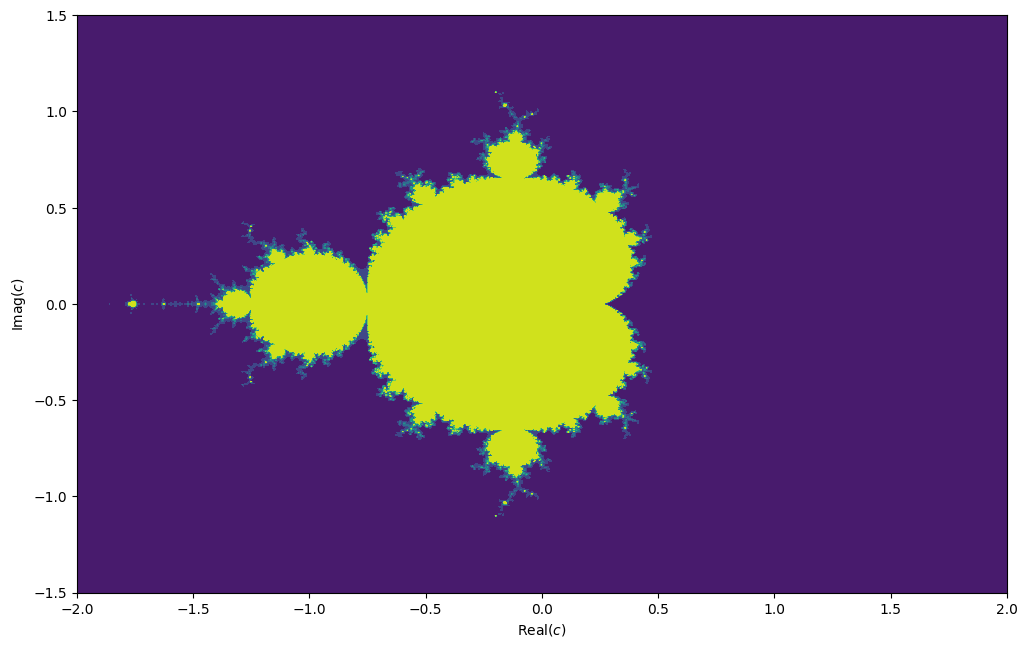

In [21]:
import pylab as plt
import numpy as np
# initial values
loop = 100 # number of interations
div = 1000 # divisions
# all possible values of c
c = np.linspace(-2,2,div)[:,np.newaxis] + 1j*np.linspace(-1.5,1.5,div)[np.newaxis,:]
# array of ones of same dimensions as c
ones = np.ones(np.shape(c), np.int32)
# Array that will hold colors for plot, initial value set here will be
# the color of the points in the mandelbrot set, i.e. where the series
# converges.
# For the code below to work, this initial value must at least be 'loop'.
# Here it is loop + 5
color = ones * loop + 5
z = 0
for n in range(0,loop):
      z = z**2 + c
      diverged = np.abs(z)>2
      # Store value of n at which series was detected to diverge.
      # The later the series is detected to diverge, the higher
      # the 'color' value.
      color[diverged] = np.minimum(color[diverged], ones[diverged]*n)

plt.rcParams['figure.figsize'] = [12, 7.5]
# contour plot with real and imaginary parts of c as axes
# and colored according to 'color'
plt.contourf(c.real, c.imag, color)
plt.xlabel("Real($c$)")
plt.ylabel("Imag($c$)")
plt.xlim(-2,2)
plt.ylim(-1.5,1.5)
plt.savefig("plot.png")
plt.show()

## Version Parallélisée CUDA

(1000, 1000) (1000, 1000) (1000, 1000)


/usr/local/lib/python3.11/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.11/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


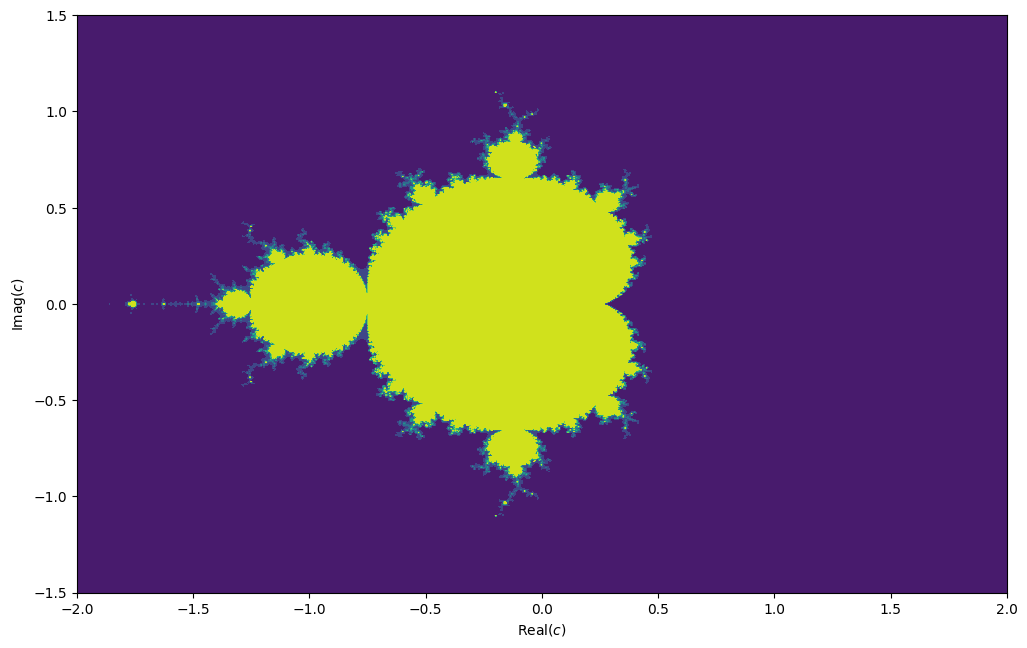

In [31]:
import pylab as plt
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

############# Definition des données #############
loop = 100 # number of interations
div = np.int32(1000) # divisions
# matrices c
c_realPart = np.linspace(-2,2,div)[:,np.newaxis]  ############## PB : la j'ai qu'une ligne, il faut que j'ai une matrice avec div fois cette ligne
c_imPart = np.linspace(-1.5,1.5,div)[np.newaxis,:]
c_realPart, c_imPart = np.meshgrid (c_realPart, c_imPart)
c_realPart = np.ascontiguousarray(c_realPart.astype(np.float32))
c_imPart = np.ascontiguousarray(c_imPart.astype(np.float32))
# Matrix color
ones = np.ones((div,div), np.int32) # array of ones of same dimensions as c
color = ones * loop + 5
# Matrices z
z_realPart = np.zeros_like(c_realPart)
z_imPart = np.zeros_like(c_imPart)

############# Allocation+recup GPU des données #############
# Allocation mémoire GPU
c_realPart_gpu = cuda.mem_alloc(c_realPart.nbytes)
c_imPart_gpu = cuda.mem_alloc(c_imPart.nbytes)
color_gpu = cuda.mem_alloc(color.nbytes)
z_realPart_gpu = cuda.mem_alloc(z_realPart.nbytes)
z_imPart_gpu = cuda.mem_alloc(z_imPart.nbytes)
# Déplacement données
cuda.memcpy_htod(c_realPart_gpu, c_realPart)
cuda.memcpy_htod(c_imPart_gpu, c_imPart)
cuda.memcpy_htod(color_gpu, color)
cuda.memcpy_htod(z_realPart_gpu, z_realPart)
cuda.memcpy_htod(z_imPart_gpu, z_imPart)

############# Fonction de calcul de convergence #############
mod = SourceModule("""
__global__ void calculate_image( int dim, int loop, float *c_realPart, float *c_imPart, float *z_realPart, float *z_imPart, int *color)
{
  int idx = threadIdx.x + blockIdx.x * blockDim.x;
  int idy = threadIdx.y + blockIdx.y * blockDim.y;
  int index = idx + idy * dim;
  z_realPart[index] = 0.0f;
  z_imPart[index] = 0.0f;
  if ((idx < dim) && (idy < dim))
  {
    for(int n = 0; n<loop; n++)
    {
      // Calcul de la partie réelle et imaginaire
      float temp = z_realPart[index];
      z_realPart[index] = z_realPart[index]*z_realPart[index] - z_imPart[index]*z_imPart[index] + c_realPart[index];
      z_imPart[index] = 2 * temp * z_imPart[index] + c_imPart[index];
      // Calcul de la norme
      float norme_squared = z_realPart[index]*z_realPart[index] + z_imPart[index]*z_imPart[index];
      // Update color si divergent
      if(norme_squared>4){
        color[index] = min(color[index], n);
      }
    }
  }
}
""")

func = mod.get_function("calculate_image")
dimblk = (10, 10, 1)
dimgrd = (int(div//10), int(div//10), 1)

############# Appel de la fonction #############
func(div, np.int32(loop), c_realPart_gpu, c_imPart_gpu, z_realPart_gpu, z_imPart_gpu, color_gpu, grid=dimgrd, block=dimblk)

############# Récupération du résultat #############
cuda.memcpy_dtoh(color, color_gpu)

############# Affichage #############
plt.rcParams['figure.figsize'] = [12, 7.5]
# contour plot with real and imaginary parts of c as axes
# and colored according to 'color'
print(c_realPart.shape, c_imPart.shape, color.shape)
plt.contourf(c_realPart, c_imPart, color)
plt.xlabel("Real($c$)")
plt.ylabel("Imag($c$)")
plt.xlim(-2,2)
plt.ylim(-1.5,1.5)
plt.savefig("plot.png")
plt.show()